## <span style="color:#ff8000">Pre-Processing Data</span>

In [ ]:
import re
from pathlib import Path
import fitz  
import json

def extract_text_from_pdf(pdf_path):
    """Ekstrak teks dari file PDF menggunakan PyMuPDF."""
    text = ""
    doc = fitz.open(pdf_path)
    for page in doc:
        text += page.get_text("text") + "\n"
    # print(text)
    return text

def extract_header_info(raw_text):
    """
    Ambil header dari raw_text (sebelum marker "BAB 1 KETENTUAN UMUM")
    dan ekstrak:
      - title: baris yang cocok dengan "UNDANG-UNDANG REPUBLIK INDONESIA" 
               atau "PERATURAN PEMERINTAH REPUBLIK INDONESIA"
      - nomor_tahun: baris yang dimulai dengan "NOMOR ... TAHUN ..."
      - tentang: jika ada baris "TENTANG", ambil baris berikutnya.
    """
    # Cari marker untuk membagi header dan main text
    match = re.search(r"(?i)BAB\s+I", raw_text)
    header_text = raw_text[:match.start()] if match else raw_text

    # print("HEADER")
    # print(header_text)

    # Split header berdasarkan newline dan hilangkan spasi berlebih
    lines = [line.strip() for line in header_text.splitlines() if line.strip()]
    
    title = ""
    nomor_tahun = ""
    tentang = ""
    
    # Cari title: gunakan regex untuk match persis salah satu opsi
    for line in lines:
        if re.fullmatch(r"(?i)(UNDANG-UNDANG REPUBLIK INDONESIA|PERATURAN PEMERINTAH REPUBLIK INDONESIA)", line):
            title = line
            break
            
    # Cari nomor dan tahun: misalnya "NOMOR   40   TAHUN 2004"
    for line in lines:
        m = re.search(r"(?i)^NOMOR\s+\d+\s+TAHUN\s+\d+", line)
        if m:
            nomor_tahun = m.group(0)
            break

    # Cari tentang: jika ada baris yang tepat "TENTANG", ambil baris setelahnya
    for i, line in enumerate(lines):
        if re.fullmatch(r"(?i)TENTANG", line):
            if i + 1 < len(lines):
                tentang = lines[i + 1]
            break

    return {"title": title, "nomor_tahun": nomor_tahun, "tentang": tentang}

def preprocess_main_text(main_text):
    """
    Lakukan pembersihan pada bagian main text (setelah header).
    - Hapus pola nomor halaman (misalnya: "- 2 -")
    - Hapus baris-baris header/footer yang masih tersisa (misalnya "PRESIDEN REPUBLIK INDONESIA")
    - Normalisasi spasi di dalam setiap baris, namun pertahankan newline agar struktur dokumen terjaga.
    """
    # Hapus nomor halaman
    text = re.sub(r"\n\s*-\s*\d+\s*-\s*\n", "\n", main_text)
    
    cleaned_lines = []
    for line in text.splitlines():
        line_strip = line.strip()
        # Abaikan baris yang hanya berisi header/footer
        if re.fullmatch(r"(?i)PRESIDEN\s+REPUBLIK\s+INDONESIA", line_strip):
            continue
        if re.fullmatch(r"[-\d]+", line_strip):
            continue
        # Normalisasi spasi di dalam baris (tapi jangan hilangkan newline)
        cleaned_lines.append(re.sub(r'\s+', ' ', line_strip))
    
    # Gabungkan baris kembali dengan newline dan hapus baris kosong
    text = "\n".join([line for line in cleaned_lines if line])
    return text.strip()


def segment_by_structure(clean_text):
    """
    Segmentasikan main text (setelah header) berdasarkan struktur dokumen,
    yaitu setiap kemunculan "BAB" atau "Pasal" akan menjadi awal chunk baru.
    """
    segments = re.split(r'(?=(?:BAB|Pasal)\s+)', clean_text)
    segments = [seg.strip() for seg in segments if seg.strip()]
    return segments

def segment_by_chapter_and_pasals(clean_text):
    """
    Memecah dokumen menjadi bab dan kemudian dalam setiap bab,
    memecah berdasarkan pasal.
    
    Menggunakan regex untuk mencari pola:
      - Bab: "BAB" diikuti oleh angka Romawi (misal, "BAB I", "BAB II", dst.)
      - Pasal: "Pasal" diikuti oleh angka (misal, "Pasal 1", "Pasal 2", dst.)
    
    Mengembalikan list of dictionaries, misalnya:
    [
      {
         "chapter_header": "BAB I KETENTUAN UMUM ...", 
         "pasals": [
             "Pasal 1 ...",
             "Pasal 2 ...",
             ...
         ]
      },
      {
         "chapter_header": "BAB II ASAS, TUJUAN, DAN PRINSIP PENYELENGGARAAN ...",
         "pasals": [ ... ]
      },
      ...
    ]
    """
    # Pisahkan berdasarkan bab dengan asumsi "BAB" diikuti oleh angka Romawi
    chapters = re.split(r'(?m)(?=^BAB\s+[IVXLCDM]+\b)', clean_text)
    chapters = [ch.strip() for ch in chapters if ch.strip()]
    
    chapter_segments = []
    for chapter in chapters:
        # Ambil header bab sebagai baris pertama (bisa disesuaikan lagi jika perlu)
        # Kemudian pisahkan pasal-pasal dalam bab tersebut.
        pasals = re.split(r'(?=(?i:Pasal\s+\d+))', chapter)
        pasals = [p.strip() for p in pasals if p.strip()]
        
        # Asumsikan elemen pertama merupakan header bab.
        chapter_header = pasals[0]
        # Jika terdapat kata "Pasal" di dalam header bab, potong sebelum kata tersebut.
        chapter_header = re.split(r'(?i)\bPasal\b', chapter_header)[0].strip()

        pasal_list = pasals[1:] if len(pasals) > 1 else []
        
        chapter_segments.append({
            "chapter_header": chapter_header,
            "pasals": pasal_list
        })
        
    return chapter_segments
# --- Contoh penggunaan di Indexing Pipeline ---

def final_clean_text(text):
    # Ganti newline dengan spasi, lalu kolaps spasi berlebih
    return re.sub(r'\s+', ' ', text.replace('\n', ' ')).strip()


# Lokasi file PDF
file_path="data/PP_Nomor_28_Tahun_2024.pdf"

# 1. Ekstraksi teks dari PDF
raw_text = extract_text_from_pdf(file_path)
# print(raw_text)

# 2. Ekstrak header info dari raw_text (sebelum marker "BAB 1 KETENTUAN UMUM")
header_info = extract_header_info(raw_text)

# 3. Ambil bagian main text (dari "BAB 1 KETENTUAN UMUM" sampai selesai)
match = re.search(
    r"(?i)BAB\s+I\s*[\r\n]+\s*KETENTUAN\s+UMUM\s*[\r\n]+\s*Pasal\s+1",
    raw_text
)
main_text = raw_text[match.start():] if match else ""

# 4. Preprocess main text (khusus bagian struktur dokumen)
clean_main_text = preprocess_main_text(main_text)

# 5. Segmentasikan main text berdasarkan struktur (BAB, Pasal, dll)
# segments = segment_by_structure(clean_main_text)
chapter_data = segment_by_chapter_and_pasals(clean_main_text)

# --- Output untuk verifikasi ---

print("=== Header Info ===")
print(f"Judul      : {header_info.get('title')}")
print(f"Nomor/Tahun: {header_info.get('nomor_tahun')}")
print(f"Tentang    : {header_info.get('tentang')}\n")

print("=== Contoh Segmen Dokumen (Bagian Kedua) ===")
# for idx, seg in enumerate(segments[:3], start=1):
#     print(f"Segment {idx}:\n{seg[:500]}...\n")
for chapter in chapter_data:
    chapter["chapter_header"] = final_clean_text(chapter["chapter_header"])
    chapter["pasals"] = [final_clean_text(pasal) for pasal in chapter["pasals"]]
print(chapter_data[0])
# for idx, chapter in enumerate(chapter_data[:2], start=1):
#     print(f"Chapter {idx}: {chapter['chapter_header'][:200]}...\n")
#     for jdx, pasal in enumerate(chapter['pasals'], start=1):
#         print(f"{pasal[:200]}...\n")

=== Header Info ===
Judul      : PERATURAN PEMERINTAH REPUBLIK INDONESIA
Nomor/Tahun: NOMOR 28 TAHUN 2024
Tentang    : PERATURAN PEI,J.KSANAAN UNDANG-UNDANG NOMOR 17 TAHUN 2023

=== Contoh Segmen Dokumen (Bagian Kedua) ===
{'chapter_header': 'BAB I KETENTUAN UMUM', 'pasals': ['Pasal 1 Dalam Peraturan Pemerintah ini yang dimaksud dengan: 1. Kesehatan adalah keadaan sehat seseorang, baik secara fisik, jiwa, maupun sosial dan bukan sekadar terbebas dari penyakit untuk memungkinkannya hidup produktif. 2. Upaya Kesehatan adalah segala bentuk kegiatan dan/atau serangkaian kegiatan yang dilakukan secara terpadu dan berkesinambungan untuk memelihara dan meningkatkan derajat Kesehatan masyarakat dalam bentuk promotif, preventif, kuratif, rehabilitatif, dan/atau paliatif oleh pemerintah pusat, pemerintah daerah, dan/atau masyarakat. 3. Pelayanan Kesehatan adalah segala bentuk kegiatan dan/atau serangkaian kegiatan pelayanan yang diberikan secara langsung kepada perseorangan atau masyarakat untuk

In [58]:
# # 2. Pre-processing: Bersihkan teks dari header/footer dan noise
# clean_text = preprocess_pdf_text(raw_text)

# # 3. Pisahkan menjadi dua bagian:
# #    Bagian pertama: sebelum "BAB 1 KETENTUAN UMUM"
# #    Bagian kedua: dari "BAB 1 KETENTUAN UMUM" sampai selesai
# split_marker = re.search(r"(BAB\s+1\s+KETENTUAN\s+UMUM)", clean_text, re.IGNORECASE)
# if split_marker:
#     split_index = split_marker.start()
#     header_text = clean_text[:split_index].strip()
#     main_text = clean_text[split_index:].strip()
# else:
#     header_text = clean_text
#     main_text = ""

# # 4. Ekstrak informasi header dari bagian pertama
# header_info = extract_header_info(header_text)

# # 5. Segmentasikan bagian kedua berdasarkan struktur dokumen (BAB, Pasal, dsb)
# segments = segment_by_structure(main_text)

# # (Opsional) Tampilkan beberapa segmen untuk verifikasi
# print("=== Header Info ===")
# print(f"Judul      : {header_info.get('title')}")
# print(f"Nomor/Tahun: {header_info.get('nomor_tahun')}")
# print(f"Tentang    : {header_info.get('tentang')}\n")

# print("=== Contoh Segmen Dokumen (Bagian Kedua) ===")
# for idx, segment in enumerate(segments[:3], start=1):
#     print(f"Segment {idx}:\n{segment[:500]}...\n")


from langchain.docstore.document import Document

# Konversi chapter_data (list of dict) ke list of Document
documents = []
for chapter in chapter_data:
    # Gabungkan chapter header dan pasal-pasal dalam satu string
    content = chapter["chapter_header"] + "\n" + "\n".join(chapter["pasals"])
    # Buat Document dengan metadata (misalnya menyimpan chapter header)
    documents.append(Document(page_content=content, metadata={"chapter": chapter["chapter_header"]}))

# docs_as_dict = [
#     {"metadata": doc.metadata, "page_content": doc.page_content}
#     for doc in documents
# ]
# with open("documents_preview.json", "w", encoding="utf-8") as f:
#     json.dump(docs_as_dict, f, indent=2, ensure_ascii=False)

# print("Preview documents telah disimpan ke documents_preview.json")

## <span style="color:#ff8000">Indexing Pipeline</span>

### <span style="color:#47c7fc">Data Loading</span>

1. Retrieval

In [40]:
# Import Library
from langchain_community.document_loaders import PyPDFLoader
import textwrap

loader = PyPDFLoader(file_path, mode="single")

pdf_data = loader.load()

print(len(pdf_data[0].page_content))
print(pdf_data)

1007495
[Document(metadata={'producer': 'PyPDF', 'creator': 'PyPDF', 'creationdate': '2024-07-26T22:56:25+07:00', 'moddate': '2024-07-29T13:41:12+07:00', 'source': 'data/PP_Nomor_28_Tahun_2024.pdf', 'total_pages': 656}, page_content='SALINAN\nPRESIDEN\nREPUBLIK INDONESIA\nPERATURAN PEMERINTAH REPUBLIK INDONESIA\nNOMOR 28 TAHUN 2024\nTENTANG\nPERATURAN PEI,J.KSANAAN UNDANG-UNDANG NOMOR 17 TAHUN 2023\nTENTANG KESEHATAN\nDENGAN RAHMAT TUHAN YANG MAHA ESA\nPRESIDEN REPUBLIK INDONESIA,\nMenimbang bahwa untuk melaksanakan ketentuan Pasal 24 ayat (21,\nPasal 25 ayat (5), Pasal 33 ayat (5), Pasal 36, Pasal 40 ayat (6),\nPasal 43 ayat (2), Pasal 49, Pasal 5O ayat (6), Pasal 51 ayat (5),\nPasal 52 ayat (5), Pasal 53 ayat (6), Pasal59, Pasal62, Pasal69,\nPasal 73, Pasal 85, Pasal 92, Pasal 95, Pasal 96 ayat (6),\nPasal 97 ayat (6), Pasal 101, Pasal 107, Pasal 108 ayat (4),\nPasal 1 13, Pasal 122, Pasal 126 ayat (21, Pasal 134, Pasal 136,\nPasal L37 ayat (3), Pasal 144, Pasal 145 ayat (4), Pasal 1

In [ ]:
# # Only to check data had retrieved
# pages = []
# async for page in loader.alazy_load():
#     pages.append(page)

# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)


In [54]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n","."],
    chunk_size=1000,
    chunk_overlap=100,
)

# pdf_doc_chunks=text_splitter.split_documents(pdf_data)
# print(pdf_doc_chunks)
pdf_doc_chunks=text_splitter.split_documents(documents)

## <span style="color:#ff8000">2. Data Splitting or Chunking</span>

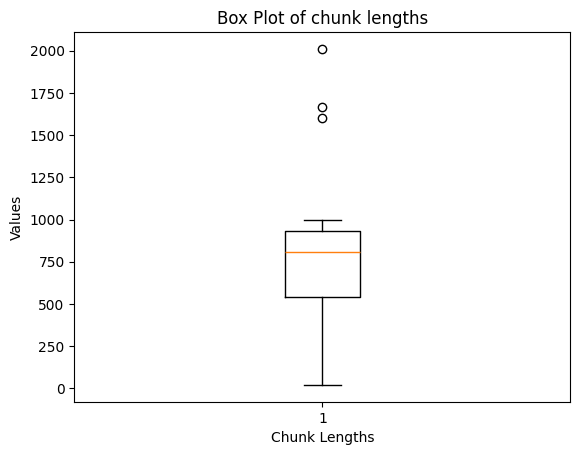

The median chunk lenght is : 806.0
The average chunk lenght is : 713.42
The minimum chunk lenght is : 20
The max chunk lenght is : 2011
The 75th percentile chunk length is : 929.5
The 25th percentile chunk length is : 539.5


In [55]:
import matplotlib.pyplot as plt
import numpy as np

data = [len(doc.page_content) for doc in pdf_doc_chunks]

plt.boxplot(data)  
plt.title('Box Plot of chunk lengths')  # Title 
plt.xlabel('Chunk Lengths')  # Label for x-axis
plt.ylabel('Values')  # Label for y-axis

plt.show()

print(f"The median chunk lenght is : {round(np.median(data),2)}")
print(f"The average chunk lenght is : {round(np.mean(data),2)}")
print(f"The minimum chunk lenght is : {round(np.min(data),2)}")
print(f"The max chunk lenght is : {round(np.max(data),2)}")
print(f"The 75th percentile chunk length is : {round(np.percentile(data, 75),2)}")
print(f"The 25th percentile chunk length is : {round(np.percentile(data, 25),2)}")

## <span style="color:#ff8000">3. Data Transformation or Embeddings</span>


In [59]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
hf_embeddings = embeddings.embed_documents([chunk.page_content for chunk in pdf_doc_chunks])

print(f"The lenght of the embeddings vector is {len(hf_embeddings[0])}")
print(f"The embeddings object is an array of {len(hf_embeddings)} X {len(hf_embeddings[0])}")

The lenght of the embeddings vector is 768
The embeddings object is an array of 1427 X 768


In [60]:
from dotenv import load_dotenv
import os

if load_dotenv():
    print("Success: .env file found with some environment variables")
else:
    print("Caution: No environment variables found. Please create .env file in the root directory or add environment variables in the .env file")

api_key=os.environ["OPENAI_API_KEY"]

from openai import OpenAI

client = OpenAI()

if api_key:
    try:
        client.models.list()
        print("OPENAI_API_KEY is set and is valid")
    except openai.APIError as e:
        print(f"OpenAI API returned an API Error: {e}")
        pass
    except openai.APIConnectionError as e:
        print(f"Failed to connect to OpenAI API: {e}")
        pass
    except openai.RateLimitError as e:
        print(f"OpenAI API request exceeded rate limit: {e}")
        pass

else:
    print("Please set you OpenAI API key as an environment variable OPENAI_API_KEY")

Success: .env file found with some environment variables
OPENAI_API_KEY is set and is valid


In [61]:
from langchain_openai import OpenAIEmbeddings

os.environ["TOKENIZERS_PARALLELISM"]="false"

pdf_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
pdf_doc_embeddings=embeddings.embed_documents([chunk.page_content for chunk in pdf_doc_chunks])

print(f"The lenght of the embeddings vector is {len(pdf_doc_embeddings[0])}")
print(f"The embeddings object is an array of {len(pdf_doc_embeddings)} X {len(pdf_doc_embeddings[0])}")

The lenght of the embeddings vector is 768
The embeddings object is an array of 1427 X 768


## <span style="color:#ff8000">4. Vector Storage</span>

In [62]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

storage_file_path="./memory"
storage_index_name="PDF_index"

index = faiss.IndexFlatIP(len(pdf_doc_embeddings[0]))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

vector_store.add_documents(documents=pdf_doc_chunks)
vector_store.save_local(folder_path=storage_file_path,index_name=storage_index_name)

## <span style="color:#ff8000">Generation Pipeline</span>

## <span style="color:#ff8000">1. Retrieval</span>

In [64]:
# Load the FAISS vector store with safe deserialization
vector_store = FAISS.load_local(folder_path=storage_file_path, index_name=storage_index_name, embeddings=embeddings, allow_dangerous_deserialization=True)

# Define a query
query = "Apa saja upaya Kesehatan ibu pada pascapersalinan?"

# Perform similarity search
retrieved_docs = vector_store.similarity_search(query, k=5)  # Get top 2 relevant chunks

# Display results
for i, doc in enumerate(retrieved_docs):
    print(textwrap.fill(f"\nRetrieved Chunk {i+1}:\n{doc.page_content}",width=100))
    print("\n\n")

 Retrieved Chunk 1: Pasal 10 ayat (1) diberikan untuk ibu dan bayi baru lahir. (6) Upaya Kesehatan
ibu pada pascapersalinan sebagaimana dimaksud pada ayat (5) paling sedikit berupa: a. pemberian
komunikasi, informasi, dan edukasi; b. pelayanan konseling; c. pelayanan skrining komplikasi; d.
tata laksana dan rtrjukan kasus komplikasi; dan e. pelayanan kontrasepsi. (71 Ibu dan bayi dengan
faktor risiko, komplikasi, dan kegawatdaruratan pada masa kehamilan, persalinan, dan pascapersalinan
dirujuk ke Fasilitas Pelayanan Kesehatan dengan tepat waktu sesuai dengan mekanisme sistem rujukan.
Pasal 12 (1) Upaya Kesehatan ibu sebagaimana dimaksud dalam Pasal 11 dilakukan oleh Tenaga Medis dan
Tenaga Kesehatan sesuai dengan kompetensi dan kewenangannya. (2) Upaya Kesehatan ibu sebagaimana
dimaksud pada ayat (1) dapat dibantu oleh Tenaga Pendukung atau Penunjang Kesehatan sesuai dengan
kompetensi dan kewenangannya.



 Retrieved Chunk 2: . Paragraf 7 Pelaksanaan Kegiatan Pasca-Wabah



 Retrieved 

## <span style="color:#ff8000">2. Augmentation</span>

In [65]:
retrieved_context=retrieved_docs[0].page_content + retrieved_docs[1].page_content + retrieved_docs[2].page_content + retrieved_docs[3].page_content + retrieved_docs[4].page_content

# Creating the prompt
augmented_prompt=f"""

Given the context below answer the question.

Question: {query} 

Context : {retrieved_context}

Remember to answer only based on the context provided and not from any other source. 

If the question cannot be answered based on the provided context, say I don’t know.

"""

print(textwrap.fill(augmented_prompt,width=150))

  Given the context below answer the question.  Question: Apa saja upaya Kesehatan ibu pada pascapersalinan?   Context : Pasal 10 ayat (1) diberikan
untuk ibu dan bayi baru lahir. (6) Upaya Kesehatan ibu pada pascapersalinan sebagaimana dimaksud pada ayat (5) paling sedikit berupa: a. pemberian
komunikasi, informasi, dan edukasi; b. pelayanan konseling; c. pelayanan skrining komplikasi; d. tata laksana dan rtrjukan kasus komplikasi; dan e.
pelayanan kontrasepsi. (71 Ibu dan bayi dengan faktor risiko, komplikasi, dan kegawatdaruratan pada masa kehamilan, persalinan, dan pascapersalinan
dirujuk ke Fasilitas Pelayanan Kesehatan dengan tepat waktu sesuai dengan mekanisme sistem rujukan. Pasal 12 (1) Upaya Kesehatan ibu sebagaimana
dimaksud dalam Pasal 11 dilakukan oleh Tenaga Medis dan Tenaga Kesehatan sesuai dengan kompetensi dan kewenangannya. (2) Upaya Kesehatan ibu
sebagaimana dimaksud pada ayat (1) dapat dibantu oleh Tenaga Pendukung atau Penunjang Kesehatan sesuai dengan kompetensi d

## <span style="color:#ff8000">3. Generation</span>

In [66]:
from langchain_openai import ChatOpenAI


# Set up LLM and embeddings
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
)

messages=[("human",augmented_prompt)]

ai_msg = llm.invoke(messages)
ai_msg.content
print(ai_msg.content)

Upaya Kesehatan ibu pada pascapersalinan sebagaimana dimaksud dalam konteks tersebut paling sedikit berupa: 
a. pemberian komunikasi, informasi, dan edukasi; 
b. pelayanan konseling; 
c. pelayanan skrining komplikasi; 
d. tata laksana dan rujukan kasus komplikasi; dan 
e. pelayanan kontrasepsi.


## <span style="color:#ff8000">Evaluation</span>


### 2.1 Creation of Synthetic Data

In [ ]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper


generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))

from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
# dataset = generator.generate_with_langchain_docs(pdf_data, testset_size=10)
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)

sample_queries_pdf = dataset.to_pandas()['user_input'].to_list()
expected_responses_pdf=dataset.to_pandas()['reference'].to_list()

dataset_to_eval=[]

for query, reference in zip(sample_queries_pdf,expected_responses_pdf):
    rag_call_response=rag_function(query=query, db_path="./memory", index_name=storage_index_name)
    relevant_docs=rag_call_response[0]
    response=rag_call_response[1]
    dataset_to_eval_pdf.append(
        {
            "user_input":query,
            "retrieved_contexts":relevant_docs,
            "response":response,
            "reference":reference
        }
    )

evaluation_dataset_pdf = EvaluationDataset.from_list(dataset_to_eval_pdf)

NameError: name 'html_data_transformed' is not defined

In [ ]:
from ragas import EvaluationDataset
evaluation_dataset = EvaluationDataset.from_list(dataset_to_eval)

from ragas import evaluate

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))

from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, AnswerCorrectness, ResponseRelevancy

result = evaluate(dataset=evaluation_dataset,metrics=[LLMContextRecall(), Faithfulness(), AnswerCorrectness(), ResponseRelevancy(), FactualCorrectness()],llm=evaluator_llm)
result